In [31]:
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from knn_regression_cf import *
from f1_measure_cf import *

from collections import defaultdict

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import math
import sys
import random

# Prepare data

In [2]:
geyser_dataset_path = '/home/artem/Documents/ITMO/Master/ML/Datasets/geyser.csv'
chips_dataset_path = '/home/artem/Documents/ITMO/Master/ML/Datasets/chips.csv'
dataset_columns = ['x', 'y', 'class']

geyser_dataset = pd.read_csv(geyser_dataset_path, sep=',', header=0, names=dataset_columns)
chips_dataset = pd.read_csv(chips_dataset_path, sep=',', header=0, names=dataset_columns)

### Geyser dataset

In [3]:
geyser_dataset.head()

,x,y,class
0,1,4.4,N
1,1,3.9,N
2,1,4.0,P
3,1,4.0,N
4,1,3.5,N


In [4]:
geyser_dataset.dtypes

x          int64
y        float64
class     object
dtype: object

In [5]:
geyser_dataset.describe()

,x,y
count,222.000000,222.000000
mean,12.297297,3.576126
std,7.862615,1.083950
min,1.000000,1.700000
25%,5.000000,2.300000
50%,16.000000,4.000000
75%,20.000000,4.400000
max,23.000000,5.200000


In [6]:
geyser_ds_targets = geyser_dataset['class'].unique()
geyser_ds_digit_targets = [-1, 1]

In [7]:
geyser_ds_x = geyser_dataset.drop('class', axis='columns')
geyser_ds_y = geyser_dataset['class']

In [8]:
geyser_ds_y_digits = geyser_ds_y.replace(geyser_ds_targets, geyser_ds_digit_targets)
geyser_ds_y_digits.describe()

count    222.000000
mean      -0.207207
std        0.980508
min       -1.000000
25%       -1.000000
50%       -1.000000
75%        1.000000
max        1.000000
Name: class, dtype: float64

In [9]:
geyser_ds_x_offset = geyser_ds_x.mean()
geyser_ds_x_scale = geyser_ds_x.std()
geyser_ds_x_norm = (geyser_ds_x - geyser_ds_x_offset) / geyser_ds_x_scale
geyser_ds_x_norm.describe()

,x,y
count,222.000000,2.220000e+02
mean,0.000000,-1.056212e-15
std,1.000000,1.000000e+00
min,-1.436837,-1.730823e+00
25%,-0.928101,-1.177292e+00
50%,0.470925,3.910456e-01
75%,0.979662,7.600662e-01
max,1.361214,1.498108e+00


In [10]:
geyser_ds_x_norm.isna().values.any()

False

### Chips dataset

In [11]:
chips_dataset.head()

,x,y,class
0,0.051267,0.69956,P
1,-0.092742,0.68494,P
2,-0.213710,0.69225,P
3,-0.375000,0.50219,P
4,-0.513250,0.46564,P


In [12]:
chips_dataset.dtypes

x        float64
y        float64
class     object
dtype: object

In [13]:
chips_dataset.describe()

,x,y
count,118.000000,118.000000
mean,0.054779,0.183102
std,0.496654,0.519743
min,-0.830070,-0.769740
25%,-0.372120,-0.254385
50%,-0.006336,0.213455
75%,0.478970,0.646562
max,1.070900,1.108900


In [14]:
chips_ds_targets = chips_dataset['class'].unique()
chips_ds_digit_targets = [-1, 1]

In [15]:
chips_ds_x = chips_dataset.drop('class', axis='columns')
chips_ds_y = chips_dataset['class']

In [16]:
chips_ds_y_digits = chips_ds_y.replace(chips_ds_targets, chips_ds_digit_targets)
chips_ds_y_digits.describe()

count    118.000000
mean       0.016949
std        1.004120
min       -1.000000
25%       -1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: class, dtype: float64

In [17]:
chips_ds_x_offset = chips_ds_x.mean()
chips_ds_x_scale = chips_ds_x.std()
chips_ds_x_norm = (chips_ds_x - chips_ds_x_offset) / chips_ds_x_scale
chips_ds_x_norm.describe()

,x,y
count,1.180000e+02,1.180000e+02
mean,2.258081e-17,5.927462e-17
std,1.000000e+00,1.000000e+00
min,-1.781621e+00,-1.833294e+00
25%,-8.595503e-01,-8.417365e-01
50%,-1.230541e-01,5.840087e-02
75%,8.540982e-01,8.917119e-01
max,2.045934e+00,1.781262e+00


In [18]:
chips_ds_x_norm.isna().values.any()

False

# Train SVM

#### V1

In [161]:
def train_svm(x_data, y_data, kernel_f, kernel_p, c, epochs=5, eps=1e-3):
    alphas = np.random.randn(len(x_data)).reshape(-1, 1)
#     w0 = random.random()
    w0 = 0
    
    errors_cache = recalculate_errors_cache(x_data, y_data, kernel_f, kernel_p, alphas, w0)
    
    for _ in range(epochs):
        num_updates = 0
        for i in range(len(x_data)):
            # choose second example for optimization
#             j = choose_j(i, errors_cache)
            j = i - 1
            if i == j:
                continue
                
            # current step data
            x1, x2 = x_data[i], x_data[j]
            y1, y2 = y_data[i], y_data[j]
            a1, a2 = alphas[i], alphas[j]

            # errors
#             error1 = errors_cache[i]
#             error2 = errors_cache[j]
            error1 = calculate_error(predict(x1, x_data, y_data, kernel_f, alphas, w0, kernel_p), y1)
            error2 = calculate_error(predict(x2, x_data, y_data, kernel_f, alphas, w0, kernel_p), y2)
            
            # calculate derivative and assert it is more than zero
            d = calculate_derivative(x1, x2, kernel_f, kernel_p)
            assert d >= 0

            # bounds
            l, h = calculate_bounds(a1, a2, c, y1, y2)

            # update alpha2
            a2_new = a2 + y2 * (error1 - error2) / (d + 1e-5)
            a2_new_clipped = max(l, min(h, a2_new))
            
            if abs(a2_new_clipped - a2) < eps * (a2 + a2_new_clipped + eps):
                continue

            # update alpha1
            a1_new = a1 + y1 * y2 * (a2 - a2_new_clipped)
        
            # store new alphas
            alphas[i], alphas[j] = a1_new, a2_new_clipped
            num_updates += 1

            # calculate weights and update threshold
            weights = (alphas * y_data * x_data).sum(axis=0)
            for x, y, alpha in zip(x_data, y_data, alphas):
                if alpha > 0 and alpha < c:
#                     w0 = x.dot(weights) - y
                    break
                    
            # recalculate errors cache
#             errors_cache = recalculate_errors_cache(x_data, y_data, kernel_f, kernel_p, alphas, w0)
        
        if num_updates == 0:
            break
    
    return alphas, w0
    
def predict(x_t, x_data, y_data, kernel_f, alphas, w0, kernel_p=1):
    p = 0
    for x, y, a in zip(x_data, y_data, alphas):
        p += y * a * kernel_f(x_t, x, kernel_p) - w0        
    return p


def calculate_error(p, y):
    return p - y


def recalculate_errors_cache(x_data, y_data, kernel_f, kernel_p, alphas, w0):
    errors = []
    for i in range(len(x_data)):
        p_i = predict(x_data[i], x_data, y_data, kernel_f, alphas, w0, kernel_p)
        error_i = calculate_error(p_i, y_data[i])
        errors.append(error_i)
    
    return errors


def choose_j(i, errors_cache):
    error_i = errors_cache[i]
    if error_i > 0:
        return np.argmin(errors_cache)
    else:
        return np.argmax(errors_cache)
    
    
def calculate_derivative(x1, x2, kernel_f, kernel_p):
    return kernel_f(x1, x1, kernel_p) + kernel_f(x2, x2, kernel_p) - 2 * kernel_f(x1, x2, kernel_p)
    

def calculate_bounds(a1, a2, c, y1, y2):
    if y1 != y2:
        l = max(0, a2 - a1)
        h = min(c, c + a2 - a1)
    else:
        l = max(0, a2 + a1 - c)
        h = min(c, a2 + a1)
    return l, h

#### V2  https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf

In [30]:
def train_svm_v2(x_data, y_data, alphas, kernel_f, kernel_p, c, w0):
    errors = [0] * len(x_data)
    
    num_changed = 0
    examine_all = True
    
    while num_changed > 0 or examine_all:
        num_changed = 0
        
        if examine_all:
            for i in range(len(x_data)):
                num_changed += examine_example(i)
        else:
            for i in range(len(x_data)):
                alpha_i = alphas[i]
                if alpha_i != 0 and alpha_i != c:
                    num_changed += examine_example(i, x_data, y_data, errors, alphas, kernel_f, kernel_p, c, w0)
        
        if examine_all:
            examine_all = False
        elif num_changed == 0:
            examine_all = True
        
        
def examine_example(i, x_data, y_data, alphas, errors, kernel_f, kernel_p, c, w0, tol=1e-3):
    x_i = x_data[i]
    y_i = y_data[i]
    alpha_i = alphas[i]
    
    p_i = predict(x_i, x_data, y_data, kernel_f, alphas, w0, kernel_p)
    error_i = calculate_error(p_i, y_i)
    
    # store errors in cache
    errors[i] = error_i
    
    r_i = y_i * error_i
    
    if (r_i < -tol and alpha_i < c) or (r_i > tol and alpha_i > 0):
        j = choose_second_example(i, errors, alphas, c)
        if take_step(i, j, error_i):
            return 1
    

def choose_second_example(i, errors):
    error_i = errors[i]
    j_chosen = -1
    if error_i > 0:
        min_error = sys.maxsize
        for j in range(len(errors)):
            error_j = errors[j]
            if error_j < min_error:
                j_chosen = j
                min_error = error_j
        
        return
    else:
        max_error = -sys.maxsize
        for j in range(len(errors)):
            error_j = errors[j]
            if error_j > max_error:
                j_chosen = j
                max_error = error_j
        
    assert j_chosen != -1
    return j_chosen
    

def take_step(i, j, error_i, x_data, y_data, alphas, errors, kernel_f, kernel_p, c, w0, eps=1e-3):
    if i == j:
        return False
    
    alpha_i, alpha_j = alphas[i], alphas[j]
    x_i, x_j = x_data[i], x_data[j]
    y_i, y_j = y_data[i], y_data[j]
    
    p_j = predict(x_j, x_data, y_data, kernel_f, alphas, w0, kernel_p)
    error_j = calculate_error(p_j, y_j)
    
    l, h = calculate_bounds(alpha_j, alpha_i, c, y_j, y_i)
    
    d = calculate_derivative(x_j, x_i, kernel_f, kernel_p)
    
    assert d > 0
    
    # update alpha_i
    alpha_i_new = alpha_i + y_i * (error_j - error_i) / (d + 1e-5)
    alpha_i_new_clipped = max(l, min(h, alpha_i_new))
    
    if abs(alpha_i_new_clipped - alpha_i) < eps * (alpha_i + alpha_i_new_clipped + eps):
        return False
    
    # update alpha_j
    alpha_j_new = alpha_j + y_j * y_i * (alpha_i - alpha_i_new_clipped)
    
    # update threshold
    j_is_valid = alpha_j_new <= 0 or alpha_j_new >= c
    i_is_valid = alpha_i_new_clipped <= 0 or alpha_i_new_clipped >= c
    
    w0_j = (error_j + y_j * (alpha_j_new - alpha_j) * kernel_f(x_j, x_j, kernel_p) 
            + y_i * (alpha_i_new_clipped - alpha_i) * kernel_f(x_j, x_i, kernel_p) + w0)
    w0_i = (error_i + y_j * (alpha_j_new - alpha_j) * kernel_f(x_j, x_i, kernel_p) 
            + y_i * (alpha_i_new_clipped - alpha_i) * kernel_f(x_i, x_i, kernel_p) + w0)
    
    if not j_is_valid and not i_is_valid:
        w0_new = (w0_i + w0_j) / 2
    else:
        w0_new = w0_j if j_is_valid else w0_i
    
    w_new = w + y_j * (alpha_j_new - alpha_j) * x_j + y_i * (alpha_i_new_clipped - alpha_i) * x_i
    
    pass
 

#### Kernel functions

In [76]:
def linear_kernel(x1, x2, fake_param=1):
    return x1.dot(x2)


def polynomial_kernel(x1, x2, power=1):
    return (x1.dot(x2) + 1) ** power


def gaussian_radial_kernel(x1, x2, phi=1):
    x_diff = x1 - x2
    return math.exp(-phi * x_diff.dot(x_diff))

#### Loss functions

In [87]:
def calculate_accuracy(y_predicted, y_test):
    return (y_predicted * y_test > 0).sum() / len(y_test)

### Geyser dataset

In [101]:
def examine_kernel(ds_x, ds_y, kernel_f, c, kernel_param=1):
    k_folds = 5
    ds_size = len(geyser_ds_x_norm)
    fold_size = int(ds_size / k_folds)

    test_errors = []

    for i in range(0, len(geyser_ds_x_norm), fold_size):
        test_indices = list(range(i, min(ds_size, i + fold_size), 1))

        x_train = geyser_ds_x_norm.drop(test_indices, axis='index').values
        y_train = geyser_ds_y_digits.drop(test_indices, axis='index').values.reshape(-1, 1)
        x_test = geyser_ds_x_norm.iloc[test_indices].values
        y_test = geyser_ds_y_digits.iloc[test_indices].values.reshape(-1, 1)

        alphas, w0 = train_svm(x_train, y_train, kernel_f, kernel_param, c, epochs=1)

        y_ps = []
        for x_t in x_test:
            y_p = predict(x_t, x_train, y_train, kernel_f, alphas, w0, kernel_param)
            y_ps.append(y_p)

        test_errors.append(calculate_accuracy(np.array(y_ps), y_test))
    
    return alphas, w0

    print('C: {} | Kernel param: {} | Mean error: {}'.format(c, kernel_param, np.array(test_errors).mean()))

In [89]:
cs = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
for c in cs:
    examine_kernel(geyser_ds_x_norm, geyser_ds_y_digits, linear_kernel, c)

C: 0.05 | Kernel param: 1 | Mean error: 0.9015151515151515
C: 0.1 | Kernel param: 1 | Mean error: 0.8939393939393939
C: 0.5 | Kernel param: 1 | Mean error: 0.9053030303030303
C: 1.0 | Kernel param: 1 | Mean error: 0.8939393939393939
C: 5.0 | Kernel param: 1 | Mean error: 0.8901515151515151
C: 10.0 | Kernel param: 1 | Mean error: 0.912878787878788
C: 50.0 | Kernel param: 1 | Mean error: 0.8977272727272728
C: 100.0 | Kernel param: 1 | Mean error: 0.8636363636363636


In [90]:
cs = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
powers = [2, 3, 4, 5]
for c in cs:
    for power in powers:
        examine_kernel(geyser_ds_x_norm, geyser_ds_y_digits, polynomial_kernel, c, power)

C: 0.05 | Kernel param: 2 | Mean error: 0.8522727272727272
C: 0.05 | Kernel param: 3 | Mean error: 0.9053030303030303
C: 0.05 | Kernel param: 4 | Mean error: 0.9166666666666666
C: 0.05 | Kernel param: 5 | Mean error: 0.8787878787878788
C: 0.1 | Kernel param: 2 | Mean error: 0.8068181818181818
C: 0.1 | Kernel param: 3 | Mean error: 0.9053030303030303
C: 0.1 | Kernel param: 4 | Mean error: 0.9053030303030303
C: 0.1 | Kernel param: 5 | Mean error: 0.8825757575757577
C: 0.5 | Kernel param: 2 | Mean error: 0.912878787878788
C: 0.5 | Kernel param: 3 | Mean error: 0.9015151515151515
C: 0.5 | Kernel param: 4 | Mean error: 0.8939393939393939
C: 0.5 | Kernel param: 5 | Mean error: 0.8939393939393939
C: 1.0 | Kernel param: 2 | Mean error: 0.8484848484848485
C: 1.0 | Kernel param: 3 | Mean error: 0.8863636363636364
C: 1.0 | Kernel param: 4 | Mean error: 0.875
C: 1.0 | Kernel param: 5 | Mean error: 0.8825757575757577
C: 5.0 | Kernel param: 2 | Mean error: 0.8409090909090909
C: 5.0 | Kernel param: 3

In [91]:
cs = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]
phis = [1, 2, 3, 4, 5]
for c in cs:
    for phi in phis:
        examine_kernel(geyser_ds_x_norm, geyser_ds_y_digits, gaussian_radial_kernel, c, phi)

C: 0.05 | Kernel param: 1 | Mean error: 0.8825757575757577
C: 0.05 | Kernel param: 2 | Mean error: 0.9242424242424243
C: 0.05 | Kernel param: 3 | Mean error: 0.9090909090909091
C: 0.05 | Kernel param: 4 | Mean error: 0.9166666666666666
C: 0.05 | Kernel param: 5 | Mean error: 0.8939393939393939
C: 0.1 | Kernel param: 1 | Mean error: 0.912878787878788
C: 0.1 | Kernel param: 2 | Mean error: 0.912878787878788
C: 0.1 | Kernel param: 3 | Mean error: 0.9204545454545454
C: 0.1 | Kernel param: 4 | Mean error: 0.9090909090909092
C: 0.1 | Kernel param: 5 | Mean error: 0.9053030303030303
C: 0.5 | Kernel param: 1 | Mean error: 0.912878787878788
C: 0.5 | Kernel param: 2 | Mean error: 0.912878787878788
C: 0.5 | Kernel param: 3 | Mean error: 0.9242424242424243
C: 0.5 | Kernel param: 4 | Mean error: 0.9090909090909092
C: 0.5 | Kernel param: 5 | Mean error: 0.9204545454545454
C: 1.0 | Kernel param: 1 | Mean error: 0.9015151515151515
C: 1.0 | Kernel param: 2 | Mean error: 0.912878787878788
C: 1.0 | Kerne

### Best kernel params

In [102]:
alphas_lin, w0_lin = examine_kernel(geyser_ds_x_norm, geyser_ds_y_digits, linear_kernel, c=0.5)

In [103]:
alphas_pol, w0_pol = examine_kernel(geyser_ds_x_norm, geyser_ds_y_digits, polynomial_kernel, c=0.5, kernel_param=3)

In [104]:
alphas_gaus, w0_gaus = examine_kernel(geyser_ds_x_norm, geyser_ds_y_digits, gaussian_radial_kernel, c=5.0, kernel_param=3)

### Plot hyperplane

In [168]:
def plot_hyperplane(x_data, y_data, kernel_f, kernel_p, alphas, w0, c):
    hyperplane_1_dim = []
    hyperplane_2_dim = []
    
    y_ps = []
    for x_t, alpha, y in zip(x_data, alphas, y_data):
        y_p = predict(x_t, x_data, y_data, kernel_f, alphas, w0, kernel_p)
        y_ps.append(y_p)
                
        if y_p * y < 0:
            hyperplane_1_dim.append(x_t[0])
            hyperplane_2_dim.append(x_t[1])
        
    x_1_dim = x_data[:, 0]
    x_2_dim = x_data[:, 1]
    
    plt.scatter(x_1_dim, x_2_dim)
    plt.scatter(hyperplane_1_dim, hyperplane_2_dim)

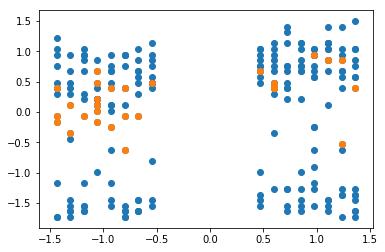

In [169]:
plot_hyperplane(geyser_ds_x_norm.values, geyser_ds_y_digits.values, linear_kernel, 1, alphas_lin, w0_lin, c=0.5)